In [4]:
import numpy as np
import cvxopt
import struct
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.patches import Polygon
import matplotlib.cm as cmx
import matplotlib.colors as colors

## Without obstacles

In [9]:
del_t = 0.1
planning_horizon = 20
control_horizon = 5
vx_guess = np.random.randint(20, size=(planning_horizon))
vy_guess = np.random.randint(20, size=(planning_horizon))
vx_init = vx_guess
vy_init = vy_guess
obst_rad = 2
obst_pos = [40,0]

class multi_mpc_agent:
    def __init__(self,rad,start,goal,vxmax,vymax):
        self.rad = rad
        self.obst_rad = obst_rad
        self.obst = obst_pos
        self.xpath = []
        self.ypath = []
        self.vxplot = []
        self.vyplot = []
        self.time = 0
        self.goal = goal
        self.vx = vx_init
        self.vy = vy_init
        self.pos = start
        self.vxmax = vxmax
        self.vymax = vymax
        
        plt.ion()
        self.dummy_x = np.array([])
        self.dummy_y = np.array([])
        self.vxlist = []
        self.vylist = []
        
    def __str__(self):
        return (str(self.time)+" "+str(self.pos))    
            
    def p_constructor(self):
        A = np.ones((planning_horizon,1))
        P = 2*del_t**2*np.matmul(A,A.T)
        net_P = np.kron(np.eye(2),P)
        q_gen = 2*del_t*A
        return net_P,q_gen
    
   
    def is_pos_def(self,x):
        return np.all(np.linalg.eigvals(x) >= 0)

    def opt_traj(self):
        self.visualize_traj()
        print ("start vx: ",self.vx,"start vy: ",self.vy)
        
        while (np.linalg.norm(self.pos-self.goal)>0.6):
            vx_new = self.vx
            vy_new = self.vy
            diff_vx = 999
            diff_vy = 999
            tol = 1e-1
            
            while (np.linalg.norm(np.array([diff_vy,diff_vx])**2)>tol):
                P,q = self.p_constructor()
                P += 1e-6*np.eye(P.shape[0])
                q = np.concatenate(((self.pos[0]-self.goal[0])*q,(self.pos[1]-self.goal[1])*q),axis=0)
                P = cvxopt.matrix(P,tc='d')
                q = cvxopt.matrix(q,tc='d')
                g_mat = np.eye(2*planning_horizon)
                g_mat = np.concatenate((g_mat,-np.eye(2*planning_horizon)),axis=0)
                h_mat = np.concatenate((self.vxmax*np.ones(planning_horizon),
                                        self.vymax*np.ones(planning_horizon),
                                        np.zeros(planning_horizon),np.zeros(planning_horizon)),axis=None)
                h = cvxopt.matrix(h_mat,tc='d')
                g = cvxopt.matrix(g_mat,tc='d')
                sol = cvxopt.solvers.qp(P,q,g,h,options={'show_progress': False})
                vx_new = sol['x'][:planning_horizon] #vx
                vy_new = sol['x'][planning_horizon:] #vy
                diff_vx = np.linalg.norm(np.array(vx_new) - self.vx)
                diff_vy = np.linalg.norm(np.array(vy_new) - self.vy)
                self.vx = vx_new
                self.vy = vy_new
            
                
            print ("##########End of Optimization#############")
        
            dummy_x = []
            dummy_y = []
            temp_x = self.pos[0]
            temp_y = self.pos[1]
            for i in range(planning_horizon):
                temp_x = temp_x + self.vx[i]*del_t
                temp_y = temp_y + self.vy[i]*del_t
                dummy_x.append(temp_x)
                dummy_y.append(temp_y)

            self.dummy_x = np.array(dummy_x)
            self.dummy_y = np.array(dummy_y)
            
            for i in range(control_horizon):
                x_new = self.pos[0] + self.vx[i]*del_t
                y_new = self.pos[1] + self.vy[i]*del_t
                self.vxlist.append(self.vx[i])
                self.vylist.append(self.vy[i])
                self.xpath.append(x_new)
                self.ypath.append(y_new)
                self.pos = [x_new,y_new]
                print (self)
                self.time+=1
                self.visualize_traj()
            
        plt.figure()
        plt.plot(self.vxlist)
        plt.show()
        plt.figure()
        plt.plot(self.vylist)
             
    def visualize_traj(self):
        figure = plt.figure()
        ax = figure.add_subplot(1,1,1)
        robot = matplotlib.patches.Circle(
            (self.pos[0],self.pos[1]),
            radius = self.rad,
            edgecolor='black',
            facecolor='pink',
            linewidth=1.0,
            ls='solid',
            alpha=1,
            zorder=2)
        ax.plot([self.goal[0]], [self.goal[1]], '*', color="yellow", markersize =15,linewidth=3.0, zorder=1)
        ax.add_patch(robot)
        name = 'data/snap%s.png'%str(self.time)
        ax.plot(self.xpath,self.ypath,'g-')
        ax.plot(self.dummy_x, self.dummy_y, 'r--')
#         ax.plot(self.prev_v,self.ypath,'b-')
        ax.set_aspect('equal')
        ax.set_xlim(-10.0, 150.0)
        ax.set_ylim(-10.0, 150.0)
        ax.set_xlabel(r'$x (m)$')
        ax.set_ylabel(r'$y (m)$')
        ax.grid(True)
        plt.savefig(name, dpi = 200)
        plt.cla()
        plt.close(figure)
        return figure

start vx:  [16 13  6 10 18 15 19  7 13  1 17 17  2 16 14 11 17  5  7 16] start vy:  [14 10  3 12 17  2 16  7  3  2  2 13 16  9  8 16 10  2 10 15]
##########End of Optimization#############
0 [12.499999972633244, 2.4999999726332445]
1 [14.999999945266488, 4.999999945266489]
2 [17.499999917899732, 7.499999917899734]
3 [19.999999890532976, 9.999999890532978]
4 [22.49999986316622, 12.499999863166222]
##########End of Optimization#############
5 [24.999999805606734, 14.999999805606734]
6 [27.499999748047248, 17.499999748047248]
7 [29.999999690487762, 19.999999690487762]
8 [32.49999963292827, 22.499999632928276]
9 [34.99999957536878, 24.99999957536879]
##########End of Optimization#############
10 [37.499999427180015, 27.49999942718002]
11 [39.99999927899125, 29.999999278991247]
12 [42.49999913080248, 32.49999913080248]
13 [44.99999898261371, 34.99999898261371]
14 [47.49999883442494, 37.49999883442494]
##########End of Optimization#############
15 [49.99999822861283, 39.99999822861283]
16 [5

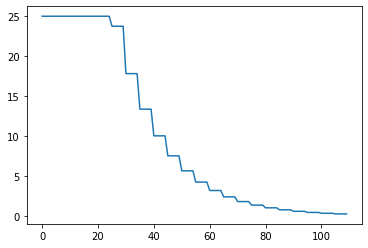

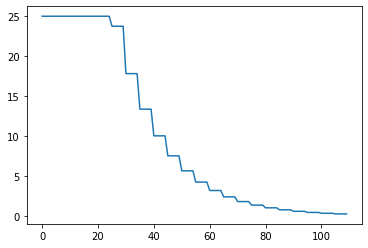

In [10]:
bot2 = multi_mpc_agent(2,np.array([10,0]),np.array([120,110]),25,25)
bot2.opt_traj()

## With obstacles

In [48]:
del_t = 0.1
planning_horizon = 20
control_horizon = 5
# vx_guess = 10*np.ones((planning_horizon))
# vy_guess = 10*np.ones((planning_horizon))
# w_guess = 0.2*np.ones((planning_horizon))
vx_guess = np.random.randint(10, size=(planning_horizon))
vy_guess = np.random.randint(10, size=(planning_horizon))
print (vx_guess,vy_guess)
# w_guess = np.random.randint(0.1, size=(planning_horizon))
vx_init = vx_guess
vy_init = vy_guess
# obst_rad = [2,3,4]
obst_rad = [3]
# obst_pos = [[40,40],[60,50],[80,80]]
obst_pos = [[40,80]]

class multi_mpc_agent:
    def __init__(self,rad,start,goal,vxmax,vymax):
        self.rad = rad
        self.obst_rad = obst_rad
        self.obst = obst_pos
        self.xpath = []
        self.ypath = []
        self.vxplot = []
        self.vyplot = []
        self.time = 0
        self.goal = goal
        self.vx = vx_init
        self.vy = vy_init
        self.vx_guess = vx_guess
        self.vy_guess = vy_guess
        self.prev_vx = vx_guess
        self.prev_vy = vy_guess
        self.pos = start
        self.vxmax = vxmax
        self.vymax = vymax
        
        plt.ion()
        self.dummy_x = np.array([])
        self.dummy_y = np.array([])
        self.vxlast = self.vx_guess[0]
        self.vylast = self.vy_guess[0]
        self.vxlist = []
        self.vylist = []
        
    def __str__(self):
        return (str(self.time)+" "+str(self.pos))    
            
    def p_constructor(self):
#         nterms = planning_horizon*(planning_horizon-1)//2
        A = np.ones((planning_horizon,1))
        P = 2*del_t**2*np.matmul(A,A.T)
        net_P = np.kron(np.eye(2),P)
        q_gen = 2*del_t*A
        return net_P,q_gen
    
    def obst_constraint(self,i,ob):
        x_g = self.pos[0]+np.sum(self.vx_guess[:i]*del_t)
        y_g = self.pos[1]+np.sum(self.vy_guess[:i]*del_t)
        A = np.concatenate((np.ones((i,1)),np.zeros((planning_horizon-i,1))),axis=0)
#         x_g = self.pos[0]+np.matmul(A.T,self.vx_guess)
#         y_g = self.pos[1]+np.matmul(A.T,self.vy_guess)
        f_0 = (x_g-self.obst[ob][0])**2+(y_g-self.obst[ob][1])**2
        coeffx = 2*(x_g-self.obst[ob][0])*del_t
        coeffy = 2*(y_g-self.obst[ob][1])*del_t
        c_0 = -np.sum(coeffx*self.vx_guess[:i] + coeffy*self.vy_guess[:i])
        gx_term = coeffx*A
        gy_term = coeffy*A
        g_term = np.concatenate((gx_term,gy_term),axis=0)
#         print (g_term)
        net_constant = (f_0-c_0)
#         print (g_term.shape)
        return g_term,f_0,c_0
   
    def is_pos_def(self,x):
        return np.all(np.linalg.eigvals(x) >= 0)

    def opt_traj(self):
        self.visualize_traj()
        print ("start vx: ",self.vx,"start vy: ",self.vy)
        
        while (np.linalg.norm(self.pos-self.goal)>0.6):
            vx_new = self.vx
            vy_new = self.vy
            diff_vx = 999
            diff_vy = 999
            tol = 1e-1
            
            while (np.linalg.norm(np.array([diff_vy,diff_vx])**2)>tol):
                P,q = self.p_constructor()
                P += 1e-6*np.eye(P.shape[0])
    #                 print (P)
                q = np.concatenate(((self.pos[0]-self.goal[0])*q,(self.pos[1]-self.goal[1])*q),axis=0)
    #                 print (P,q)
                P = cvxopt.matrix(P,tc='d')
                q = cvxopt.matrix(q,tc='d')
                g_mat = np.eye(2*planning_horizon)
                g_mat = np.concatenate((g_mat,-np.eye(2*planning_horizon)),axis=0)
                g_mat = np.concatenate((g_mat,np.eye(2*planning_horizon)),axis=0)
                g_mat = np.concatenate((g_mat,-np.eye(2*planning_horizon)),axis=0)
                h_mat = np.concatenate((self.vxmax*np.ones(planning_horizon),
                                        self.vymax*np.ones(planning_horizon),
                                        np.zeros(planning_horizon),np.zeros(planning_horizon),
                                        self.vx_guess+5,self.vy_guess+5,-(self.vx_guess-5),
                                        -(self.vy_guess-5)),axis=None)
#                 h_mat = np.concatenate((self.vxmax*np.ones(planning_horizon),
#                                         self.vymax*np.ones(planning_horizon),
#                                         np.zeros(planning_horizon),np.zeros(planning_horizon)),axis=None)
                ##For collision avoidance
#                 print (self.pos[0]-self.obst[0],self.pos[1]-self.obst[1])
                for ob in range(len(self.obst)):
                    if (np.linalg.norm(np.array(self.pos)-np.array(self.obst[ob]))<20):
                        print ("I'm checking for collision")
                        for i in range(planning_horizon):
                            gterm,cons,obst_con = self.obst_constraint(i+1,ob)
                            g_mat = np.concatenate((g_mat,-gterm.T),axis=0)
                            padding = 2
                            rhs = -(-cons+(self.obst_rad[ob]+self.rad+2)**2+0.5-obst_con)
    #                         h_mat = np.append(h_mat, rhs)
                            h_mat = np.concatenate((h_mat,rhs),axis=None)
#                     print (g_mat)
                h = cvxopt.matrix(h_mat,tc='d')
                g = cvxopt.matrix(g_mat,tc='d')
                init_vals = np.concatenate((self.vx_guess,self.vy_guess),axis=None)
                sol = cvxopt.solvers.qp(P,q,g,h,options={'show_progress': False})
                vx_new = sol['x'][:planning_horizon] #vx
                vy_new = sol['x'][planning_horizon:] #vy
#                 print ("Optimizer op:",vx_new,vy_new)
#                 print ("Opti going on...")
                diff_vx = np.linalg.norm(np.array(vx_new) - self.vx)
                diff_vy = np.linalg.norm(np.array(vy_new) - self.vy)
#                 print (diff_v,diff_w)
                self.vx = vx_new
                self.vy = vy_new
                self.prev_vx = np.array(vx_new)
                self.prev_vy = np.array(vy_new)
#                 print (self.v,self.w)
                
                self.vx_guess = self.prev_vx
                self.vx_guess = self.vx_guess.reshape((-1,))
                self.vy_guess = self.prev_vy
                self.vy_guess = self.vy_guess.reshape((-1,))
            
                
            print ("##########End of Optimization#############")
            print ("Opti complete")
        
            dummy_x = []
            dummy_y = []
            temp_x = self.pos[0]
            temp_y = self.pos[1]
            for i in range(planning_horizon):
                temp_x = temp_x + self.vx[i]*del_t
                temp_y = temp_y + self.vy[i]*del_t
                dummy_x.append(temp_x)
                dummy_y.append(temp_y)

            self.dummy_x = np.array(dummy_x)
            self.dummy_y = np.array(dummy_y)
            
            for i in range(control_horizon):
                x_new = self.pos[0] + self.vx[i]*del_t
                y_new = self.pos[1] + self.vy[i]*del_t
                self.vxlist.append(self.vx[i])
                self.vylist.append(self.vy[i])
                self.xpath.append(x_new)
                self.ypath.append(y_new)
                self.pos = [x_new,y_new]
                print (self)
                self.time+=1
                self.visualize_traj()
            self.vxlast = self.vx[control_horizon-1]
            self.vylast = self.vy[control_horizon-1]
            print ("#####End of control horizon#####")
            self.vx_guess = self.vx[control_horizon:planning_horizon]
            self.vx_guess = np.concatenate((self.vx_guess,self.vx[planning_horizon-1]*np.ones([control_horizon,1])),axis=0)
            self.vx_guess = self.vx_guess.reshape((-1,))
            self.vy_guess = self.vy[control_horizon:planning_horizon]
            self.vy_guess = np.concatenate((self.vy_guess,self.vy[planning_horizon-1]*np.ones([control_horizon,1])),axis=0)
            self.vy_guess = self.vy_guess.reshape((-1,))
            
        plt.figure()
        plt.plot(self.vxlist)
        plt.show()
        plt.figure()
        plt.plot(self.vylist)
                

             
    def visualize_traj(self):
        figure = plt.figure()
        ax = figure.add_subplot(1,1,1)
        robot = matplotlib.patches.Circle(
            (self.pos[0],self.pos[1]),
            radius = self.rad,
            edgecolor='black',
            facecolor='pink',
            linewidth=1.0,
            ls='solid',
            alpha=1,
            zorder=2)
        for i in range(len(self.obst)):
            obst = matplotlib.patches.Circle(
                (self.obst[i][0],self.obst[i][1]),
                radius = self.obst_rad[i],
                edgecolor='black',
                linewidth=1.0,
                ls='solid',
                alpha=1,
                zorder=2)
            ax.add_patch(obst)
        ax.plot([self.goal[0]], [self.goal[1]], '*', color="yellow", markersize =15,linewidth=3.0, zorder=1)
        ax.add_patch(robot)
        name = 'data/snap%s.png'%str(self.time)
        ax.plot(self.xpath,self.ypath,'g-')
        ax.plot(self.dummy_x, self.dummy_y, 'r--')
#         ax.plot(self.prev_v,self.ypath,'b-')
        ax.set_aspect('equal')
        ax.set_xlim(-10.0, 150.0)
        ax.set_ylim(-10.0, 150.0)
        ax.set_xlabel(r'$x (m)$')
        ax.set_ylabel(r'$y (m)$')
        ax.grid(True)
        plt.savefig(name, dpi = 200)
        plt.cla()
        plt.close(figure)
        return figure

[6 1 1 8 5 6 9 8 4 7 6 1 3 4 3 3 3 1 3 8] [0 8 6 4 7 4 3 6 6 4 9 9 4 6 0 3 3 2 1 9]


start vx:  [6 1 1 8 5 6 9 8 4 7 6 1 3 4 3 3 3 1 3 8] start vy:  [0 8 6 4 7 4 3 6 6 4 9 9 4 6 0 3 3 2 1 9]
##########End of Optimization#############
Opti complete
0 [10.99999992370973, 20.99999997925822]
1 [11.999999847419506, 21.999999958516437]
2 [12.999999771129282, 22.999999937774653]
3 [13.999999694839012, 23.99999991703287]
4 [14.999999618548742, 24.999999896291087]
#####End of control horizon#####
##########End of Optimization#############
Opti complete
5 [15.999999523552448, 25.999999878644797]
6 [16.999999428556155, 26.999999860998507]
7 [17.99999933355986, 27.999999843352217]
8 [18.999999238563564, 28.999999825705927]
9 [19.99999914356727, 29.999999808059638]
#####End of control horizon#####
##########End of Optimization#############
Opti complete
10 [20.99999897624887, 30.99999979115314]
11 [21.999998808930474, 31.999999774246643]
12 [22.999998641612077, 32.99999975734015]
13 [23.99999847429368, 33.99999974043365]
14 [24.999998306975282, 34.999999723527154]
#####End of contr

124 [59.87947016070955, 118.49801088205713]
#####End of control horizon#####
##########End of Optimization#############
Opti complete
125 [59.88549664841562, 118.573110150211]
126 [59.891523136121684, 118.64820941836572]
127 [59.89754962382775, 118.72330868652014]
128 [59.9035761115338, 118.79840795467409]
129 [59.90960259923987, 118.87350722282865]
#####End of control horizon#####
##########End of Optimization#############
Opti complete
130 [59.914122488238405, 118.929831720894]
131 [59.91864237723694, 118.98615621895947]
132 [59.92316226623548, 119.04248071702567]
133 [59.92768215523402, 119.09880521508896]
134 [59.932202044232554, 119.15512971315506]
#####End of control horizon#####
##########End of Optimization#############
Opti complete
135 [59.93559201802426, 119.19737312192434]
136 [59.938981991815965, 119.23961653069628]
137 [59.94237196560767, 119.28185993946548]
138 [59.945761939399375, 119.32410334823632]
139 [59.94915191319108, 119.36634675700704]
#####End of control horizo

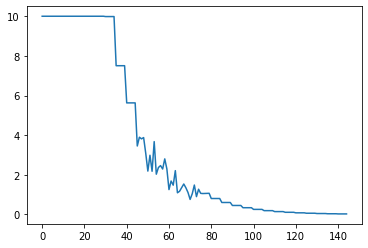

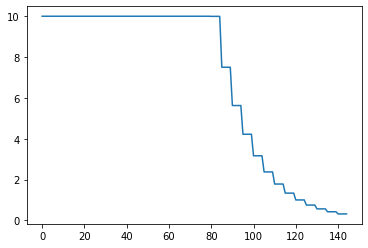

In [49]:
bot2 = multi_mpc_agent(2,np.array([10,20]),np.array([60,120]),10,10)
bot2.opt_traj()